# Optogenetic Model Evaluation

In [39]:
%load_ext autoreload
%autoreload 2
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(['seaborn-paper'])
matplotlib.rcParams['font.sans-serif'] = "Open Sans"
sys.path.append(os.path.dirname(os.getcwd()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Light Model

### 3D graphic
First we'll compare the model to figure 2A from Foutz et al. 2012.

| <img src="foutz12_2a.jpg" alt="Foutz et al. 2012 Figure 2A" width="500"> |
| - |
| <img src="foutz12_2a_replicated.png" alt="replicated Foutz et al. 2012 Figure 2A" width="500"> |

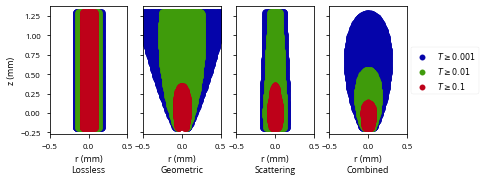

In [40]:
from matplotlib import colors
from brian2 import mm
import brian2.units.unitsafefunctions as usf

from cleosim.opto import *

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=FourStateModel(ChR2_four_state),
    light_model_params=default_blue,
)

x = np.linspace(-0.9, 0.9, 200)
y = np.linspace(-0.2, 1.3, 300)
x, y = np.meshgrid(x, y)
dir_uvec = np.array([[0], [1]])

coords = np.vstack([x.flatten(), y.flatten()]).T
coords = coords * mm
z = usf.dot(coords, dir_uvec)  # distance along cylinder axis
r = np.sqrt(np.sum((coords - usf.dot(z, dir_uvec.T)) ** 2, axis=1))
r = r.reshape((-1, 1))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
ax1.set_ylabel("z (mm)")


def plot_panel(ax, T, label):
    # filter out points with <0.001 transmittance to make plotting faster
    blue_T = 0.001
    idx_to_plot = T[:, 0] >= blue_T
    x_plot = x.flatten()[idx_to_plot]
    y_plot = y.flatten()[idx_to_plot]
    T = T[idx_to_plot, 0]

    def plot_interval(start, stop, color):
        idxs = (T >= start) & (T < stop)
        ax.scatter(x_plot[idxs], y_plot[idxs], c=color, marker="o", label=f'$T \geq {start}$')

    plot_interval(0.001, 0.01, "xkcd:royal blue")
    plot_interval(0.01, 0.1, "xkcd:grass green")
    plot_interval(0.1, 1, "xkcd:scarlet")
    ax.set_aspect("equal")
    ax.set_xlim((-0.5, 0.5))
    ax.set_xlabel(f"r (mm)\n{label}")


plot_panel(
    ax1, opto._Foutz12_transmittance(r, z, spread=False, scatter=False), "Lossless"
)
plot_panel(ax2, opto._Foutz12_transmittance(r, z, scatter=False), "Geometric")
plot_panel(ax3, opto._Foutz12_transmittance(r, z, spread=False), "Scattering")
plot_panel(ax4, opto._Foutz12_transmittance(r, z), "Combined")
ax4.legend(loc='center left', bbox_to_anchor=(1, .5))

fig.savefig('foutz12_2a_replicated.png', bbox_inches='tight', facecolor='white')

Qualitatively it looks pretty close. The scattering plot is the most off, but that could be a result of differences in how the plots are generated. They are using 3D shells which could be sliced at an angle and I'm using point samples.

### Transmission-distance plot
Next we'll try to replicate figure 2B from Foutz et al. 2012. The x-axis represents distance from light to the cell body, ranging from 0 to 2 mm. Each line is for optic fibers of different radii.

| <img src="foutz12_2b.jpg" alt="Foutz et al. 2012 Figure 2B" width="500"/> |
| - |
| <img src="foutz12_2b_replicated.svg" alt="Foutz et al. 2012 Figure 2B" width="500"/> |

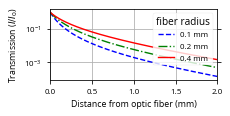

In [41]:
plt.figure(figsize=(3,1.3))
z = np.linspace(0, 2, 200)*mm
g = False
opto.light_model_params['R0'] = 0.05*mm
T1 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
opto.light_model_params['R0'] = 0.2*mm
T4 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
opto.light_model_params['R0'] = 0.1*mm
T2 = opto._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
plt.plot(z/mm, T1, 'b--', label='0.1 mm')
plt.plot(z/mm, T2, 'g-.', label='0.2 mm')
plt.plot(z/mm, T4, 'r', label='0.4 mm')
plt.yscale('log')
plt.ylabel('Transmission ($I/I_0$)')
plt.xlabel('Distance from optic fiber (mm)')
plt.legend(title='fiber radius', loc='upper right')
plt.grid(True); plt.tick_params(right=True, which='both')
plt.xlim(0, 2)
plt.savefig('foutz12_2b_replicated.svg', facecolor='white', bbox_inches='tight')

## Opsin model
Now let's see that the opsin model is working as expected. This chart is the result of the ramp protocol for ChR2 from PyRhO (Evans et al., 2016):

| <img src="pyrho_ChR2_ramp.png" alt="PyRhO ChR2 ramp protocol" width="500"/> |
| - |
| <img src="opto_ramp.svg" alt="replicated PyRhO ChR2 ramp protocol" width="500"/> |

WARNING    'spikemonitor' has been included in the network but not the object on which it depends.Setting 'spikemonitor' to inactive. [brian2.core.magic.dependency_warning]


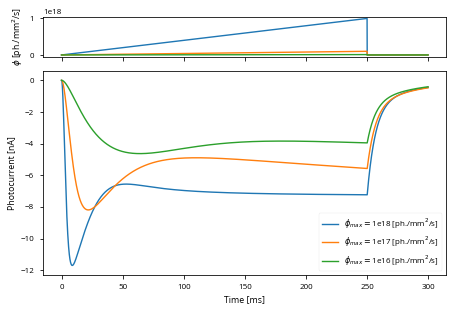

In [42]:
from brian2 import NeuronGroup, ms, StateMonitor, run, plot, Network, collect, prefs
from cleosim.coordinates import assign_coords_grid_rect_prism
prefs.codegen.target = 'numpy'

ng = NeuronGroup(3, '''
        v = -70*mV : volt
        Iopto : amp''',
)
assign_coords_grid_rect_prism(ng, (0,0), (0,0), (0,0), shape=(3, 1, 1))
opto.connect_to_neuron_group(ng)

pulse_width = 250*ms

opto_syn = opto.opto_syns[ng.name]
# converting from photon flux to irradiance at point (Irr) to fiber tip irradiance (Irr0)
# phi [1e18, 1e17, 1e16] * Ephoton / T
opto_syn.run_regularly('''pulse = t < pulse_width
        Irr0_peak = 1e18/10**i /second/mm2 * Ephoton / T
        Irr0 = pulse * Irr0_peak * (t/pulse_width)
''', name='stim')

Omon = StateMonitor(opto_syn, ['O1', 'C1', 'C2', 'O2', 'phi'], record=True)
Iopto_mon = StateMonitor(ng, ['Iopto'], record=True)

run(pulse_width + 50*ms)

### Plots
ax1 = plt.subplot2grid(shape=(5, 1), loc=(0,0))
ax1.plot(Omon.t/ms, Omon.phi.T*mm2)
ax1.set(ylabel='$\phi$ [ph./mm$^2$/s]', xticklabels=[])

ax2 = plt.subplot2grid(shape=(5, 1), loc=(1,0), rowspan=4)
ax2.plot(Iopto_mon.t/ms, -Iopto_mon.Iopto_.T/namp)
ax2.set(ylabel='Photocurrent [nA]', xlabel='Time [ms]')
# ax2.legend([str(x) for x in [18, 17, 16]])
ax2.legend(['$\phi_{max}=$1e' + str(x) + ' [ph./mm$^2$/s]' for x in [18, 17, 16]])
plt.tight_layout()
plt.savefig('opto_ramp.svg', facecolor='white')

## Spatially dependent stimulation response

We will now check that neurons fire more in response to light when more propagated light reaches them. The firing rates should correlate to the light transmission profile we've already seen.

In [101]:
def make_ngs(n):
    neuron_params = {
        'a': 0.0*nsiemens, 'b': 60*pamp, 'E_L': -70*mV, 'tau_m': 20*ms,
        'R': 500*Mohm, 'theta': -50*mV, 'v_reset': -55*mV, 'Delta_T': 2*mV
    }
    ng_lif = NeuronGroup(n,
        '''dv/dt = (-(v - E_L) + R*Iopto) / tau_m : volt
        Iopto: amp
        ''',
        threshold='v>=theta',
        reset='v=E_L',
        refractory=2*ms,
        namespace=neuron_params,
        name='LIF'
    )
    ng_eif = NeuronGroup(n,
        '''dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + R*Iopto) / tau_m : volt
        Iopto : amp''',
        threshold='v>=30*mV',
        reset='v=v_reset',
        namespace=neuron_params,
        name='EIF'
    )
    ngs = [ng_lif, ng_eif]
    for ng in ngs:
        ng.v = neuron_params['E_L']
    return ngs
    

In [74]:
from brian2 import *
from cleosim.coordinates import assign_coords_grid_rect_prism

prefs.codegen.target = "numpy"

_, ng = make_ngs(150)

pop_mon = SpikeMonitor(ng, record=True)

assign_coords_grid_rect_prism(
    ng,
    xlim=(-0.25, 0.25),
    ylim=(-0.25, 0.25),
    zlim=(0.2, 1.2),
    unit=mm,
    shape=(5, 5, 6),
)

from cleosim.base import CLSimulator

net = Network(pop_mon, ng)
sim = CLSimulator(net)

from cleosim.opto import *

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=FourStateModel(ChR2_four_state),
    light_model_params=default_blue,
    location=(0, 0, 0) * mm,
)
sim.inject_stimulator(opto, ng)
opto.update(10)

sim.run(1000 * ms)

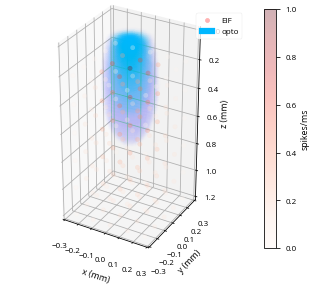

In [75]:
counts = np.bincount(pop_mon.i)
counts = np.hstack((counts, np.zeros(150 - len(counts))))

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from cleosim.visualization import _plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
neuron_artists, _ = _plot(ax, [ng], (-.3, .3), (-.3, .3), (0, 1.2), colors=['red'], devices_to_plot=[opto])

c = counts/1000
color = cm.get_cmap('Reds')(c)
neuron_artists[0].set_cmap('Reds')
neuron_artists[0].set_color(color)
plt.colorbar(neuron_artists[0], label='spikes/ms')
fig.savefig('opto_firing_rates.png', transparent=True)

## Threshold irradiance vs. pulse width and distance

Here we will replicate figure 3 of Foutz et al., 2012:

| Original | Replicated|
| - | - |
| ![Foutz et al., 2012 Figure 3](foutz12_3_original.jpg) | ![Replication of Foutz et al., 2012 Figure 3](foutz12_3_replicated.svg)|

In [128]:
from cleosim import CLSimulator
from cleosim.opto import *
from cleosim.coordinates import assign_coords_grid_rect_prism
from brian2 import *
prefs.codegen.target = 'cython'

def get_Irr0_thres(pulse_widths, distance_mm, ng, precision=1, simple_opto=False):
    mon = SpikeMonitor(ng, record=False)

    assign_coords_grid_rect_prism(
        ng,
        xlim=(0, 0),
        ylim=(0, 0),
        zlim=(distance_mm, distance_mm),
        unit=mm,
        shape=(1, 1, 1),
    )

    net = Network(mon, ng)
    sim = CLSimulator(net)

    if simple_opto:
        opto = OptogeneticIntervention(
            name="opto",
            opsin_model=ProportionalCurrentModel(
                # use 240*(thresh-E_L) factor from tutorial
                Iopto_per_mW_per_mm2=240 * (20 * mV) / (500 * Mohm)
            ),
            light_model_params=default_blue,
            location=(0, 0, 0) * mm,
        )
    else:
        opto = OptogeneticIntervention(
            name="opto",
            opsin_model=FourStateModel(ChR2_four_state),
            light_model_params=default_blue,
            location=(0, 0, 0) * mm,
        )
    sim.inject_stimulator(opto, ng)

    sim.network.store()
    Irr0_thres = []
    for pw in pulse_widths:
        search_min, search_max = (0, 10000)
        while (
            search_max - search_min > precision
        ):  # get down to {precision} mW/mm2 margin
            sim.network.restore()
            Irr0_curr = (search_min + search_max) / 2
            opto.update(Irr0_curr)
            sim.run(pw * ms)
            opto.update(0)
            sim.run(10 * ms)  # wait 10 ms to make sure only 1 spike
            if mon.count > 0:  # spiked
                search_max = Irr0_curr
            else:
                search_min = Irr0_curr
        Irr0_thres.append(Irr0_curr)

    return Irr0_thres


In [96]:
pulse_widths = np.arange(0.2, 10.2, .2)
_, ng_eif = make_ngs(1)
Irr0_thres_05 = get_Irr0_thres(pulse_widths, 0.5, ng_eif)
_, ng_eif = make_ngs(1)
Irr0_thres_10 = get_Irr0_thres(pulse_widths, 1, ng_eif)
_, ng_eif = make_ngs(1)
Irr0_thres_15 = get_Irr0_thres(pulse_widths, 1.5, ng_eif)

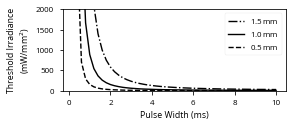

In [105]:
fig, ax = plt.subplots(figsize=(4, 1.5))
ax.plot(pulse_widths, Irr0_thres_15, 'k-.', label='1.5$\,$mm')
ax.plot(pulse_widths, Irr0_thres_10, 'k-', label='1.0$\,$mm')
ax.plot(pulse_widths, Irr0_thres_05, 'k--', label='0.5$\,$mm')
ax.set(ylim=(0, 2000), ylabel='Threshold Irradiance\n(mW/mm$^2$)', xlabel='Pulse Width (ms)')
ax.legend();
fig.savefig('foutz12_3_replicated.svg', facecolor='white', bbox_inches='tight')

We need to note the threshold irradiance for a 5 ms pulse at 1 mm distance for the next experiment:

In [130]:
Irr0_thres = {}
ng_lif, ng_eif = make_ngs(1)
Irr0_thres['LIF'] = get_Irr0_thres([5], 1, ng_lif, precision=0.001, simple_opto=True)[0]
Irr0_thres['EIF_simple'] = get_Irr0_thres([5], 1, ng_eif, precision=0.001, simple_opto=True)[0]
_, ng_eif = make_ngs(1)
Irr0_thres['EIF_markov'] = get_Irr0_thres([5], 1, ng_eif, precision=0.001)[0]
Irr0_thres

{'LIF': 8.3845853805542,
 'EIF_simple': 10.301470756530762,
 'EIF_markov': 16.930699348449707}

## Firing vs. stimulation frequency

Now we'll replicate figure 4 of Foutz et al., 2012, relating firing rate to stimulation frequency for (a) a range of irradiances and (b) a range of channel densities. Stimulation is a train of 5-ms pulses.

| Original | Replicated |
| - | - |
| <img src="foutz12_4_original.jpg" alt="Foutz et al. 2012 Figure 4" height="300"/> | <img src="foutz12_4_replicated.svg" alt="Foutz et al. 2012 Figure 4 replication" height="300"/> |

<!-- ![Foutz et al., 2012 Figure 4](foutz12_4_original.jpg) | ![Replication of Foutz et al., 2012 Figure 4](foutz12_4_replicated.svg) -->

In [120]:
# We can run all the simulations at once using 6 neurons

%load_ext autoreload
%autoreload 2
from cleosim.opto import *
from brian2 import *
prefs.codegen.target = 'numpy'

ng_lif, ng_eif_simple = make_ngs(6)
ng_eif_simple._name = 'EIF_simple'
_, ng_eif_markov = make_ngs(6)
ng_eif_markov._name = 'EIF_markov'
ngs = [ng_lif, ng_eif_simple, ng_eif_markov]
spike_mons = []
from cleosim.coordinates import assign_coords_grid_rect_prism
for ng in ngs:
    spike_mons.append(SpikeMonitor(ng, record=False))
    # distance of 1 mm
    assign_coords_grid_rect_prism(ng, xlim=(0, 0), ylim=(0, 0), 
        zlim=(1, 1), unit=mm, shape=(6,1,1))

from cleosim import CLSimulator
net = Network(*ngs, *spike_mons)  # monitors not picked up by collect()
sim = CLSimulator(net)

markov_opto = OptogeneticIntervention(
    name='markov_opto', opsin_model=FourStateModel(ChR2_four_state), 
    light_model_params=default_blue)
simple_opto = OptogeneticIntervention(
    name="simple_opto",
    opsin_model=ProportionalCurrentModel(
        # use 240*(thresh-E_L) factor from tutorial
        Iopto_per_mW_per_mm2=240 * (20 * mV) / (500 * Mohm)
    ),
    light_model_params=default_blue,
)
# neurons 3, 4, 5 have varying channel densities
sim.inject_stimulator(simple_opto, ng_lif, ng_eif_simple, rho_rel=[1, 1, 1, 1.5, 1, 0.75])
sim.inject_stimulator(markov_opto, ng_eif_markov, rho_rel=[1, 1, 1, 1.5, 1, 0.75])
# neurons 0, 1, and 2 will have varying irradiance
# achieved by modifying T
# opto.opto_syn.T = [1.4, 1.2, 1, 1.2, 1.2, 1.2] * opto.opto_syn.T
for opto_syn in opto.opto_syns.values():
    opto_syn.T[0] *= 1.4
    opto_syn.T[1] *= 1.2
    opto_syn.T[3:] *= 1.2

sim.network.store()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
firing_rates = [[] for ng in ngs]

stim_freqs = np.linspace(0.1, 200, 20)
# stim_freqs = [60]
for stim_freq in stim_freqs*Hz:
    sim.network.restore()
    # use sine curve to define pulse train
    # need threshold above which sine will be over for 5 ms at a time
    t_peak = 1 / (4*stim_freq)  # where sine curve peaks
    t_pulse_start = t_peak - 2.5*ms  # 2.5 ms to either side of peak -> 5 ms pulse
    sin_thres = sin(2*pi * stim_freq * t_pulse_start)
    simple_opto.opto_syns['LIF'].run_regularly(f'Irr0 = {Irr0_thres["LIF"]}*mwatt/mm2 * int(sin(2*pi*stim_freq*t) >= sin_thres)')
    simple_opto.opto_syns['EIF_simple'].run_regularly(f'Irr0 = {Irr0_thres["EIF_simple"]}*mwatt/mm2 * int(sin(2*pi*stim_freq*t) >= sin_thres)')
    markov_opto.opto_syns['EIF_markov'].run_regularly(f'Irr0 = {Irr0_thres["EIF_markov"]}*mwatt/mm2 * int(sin(2*pi*stim_freq*t) >= sin_thres)')
    stim_params = {'stim_freq': stim_freq, 'sin_thres': sin_thres}
    sim.run(1*second, namespace=stim_params)
    # must wrap in array to save numbers (not VariableView which will remains linked to
    # the monitor and gets overwritten with each run)
    for (fr, mon) in zip(firing_rates, spike_mons):
        fr.append(np.array(mon.count_))


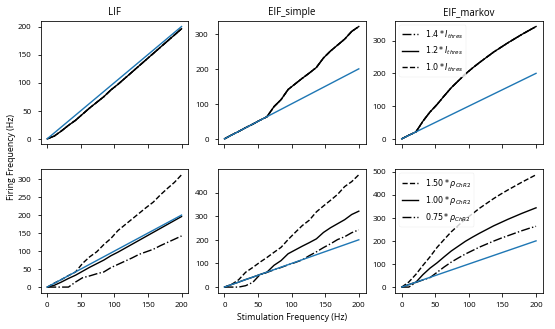

In [127]:
fig, axs = plt.subplots(2, len(ngs), figsize=(3*len(ngs), 5), sharex=True)
axs = axs.reshape((2, -1))  # to make sure axs is always 2D
for i in range(len(ngs)):
    ax1, ax2 = axs[:, i]
    fr_array = np.array(firing_rates[i])
    ax1.plot(stim_freqs, fr_array[:, 0], 'k-.', label='$1.4*I_{thres}$')
    ax1.plot(stim_freqs, fr_array[:, 1], 'k-', label='$1.2*I_{thres}$')
    ax1.plot(stim_freqs, fr_array[:, 2], 'k--', label='$1.0*I_{thres}$')
    ax1.plot(stim_freqs, stim_freqs)
    ax1.set(title=ngs[i].name)
    ax2.plot(stim_freqs, fr_array[:, 3], 'k--', label=r'$1.50*\rho_{ChR2}$')
    ax2.plot(stim_freqs, fr_array[:, 4], 'k-', label=r'$1.00*\rho_{ChR2}$')
    ax2.plot(stim_freqs, fr_array[:, 5], 'k-.', label=r'$0.75*\rho_{ChR2}$')
    ax2.plot(stim_freqs, stim_freqs)
    # ax2.set(ylim=(0, 220), xlim=(0, 200), xlabel='Stimulation Frequency (Hz)')
# fig.text(-0.02, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')
ax1.legend()
ax2.legend()

# add common ylabel
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("Firing Frequency (Hz)")
plt.xlabel("Stimulation Frequency (Hz)")

fig.savefig('foutz12_4_replicated.svg', facecolor='white', bbox_inches='tight')

### One more plot, against experimental data
These plots are similar, but from experimental data, from Gunaydin et al., 2010: "Ultrafast optogenetic control." We are told "Light power at the specimen was $1.4\,\text{mW}\,\text{mm}^{-2}$" but instead I used the $1.2 I_{thres}$ as for the previous figure.

|<img src="gunaydin10_3f_original.jpg" alt="Gunaydin et al., 2010 Fig. 3F" width=500/>|
|---|
|<img src="gunaydin10_3f_replicated.svg" alt="Gunaydin et al., 2010 Fig. 3F replication" width=500/>|

In [207]:
%load_ext autoreload
%autoreload 2
from cleosim.stimulators.opto import *
from brian2 import *

ngs = make_ngs(1)
spike_mons = []
from cleosim.coordinates import assign_coords_rect_prism
for ng in ngs:
    spike_mons.append(SpikeMonitor(ng, record=False))
    # distance of 1 mm as before
    assign_coords_rect_prism(ng, 'grid', xlim=(0, 0), ylim=(0, 0), 
        zlim=(1, 1), unit=mm, xyz_grid_shape=(1,1,1))

# vmon = StateMonitor(ngs[2], 'v', record=0)

from cleosim import CLSimulator
net = Network(*ngs, *spike_mons, )
sim = CLSimulator(net)

opto = OptogeneticIntervention(
    name='opto', start_value=0, opsin_model=four_state, 
    opsin_params=ChR2_four_state, light_model_params=default_blue, location=(0,0,0)*mm)
sim.inject_stimulator(opto, *ngs)

sim.network.store()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We need irradiance thresholds for each neuron type and for each pulse width. 

In [202]:
Irr0_thres = {ng.name: {} for ng in ngs}
pulse_widths = [1, 2, 5]
for ng in make_ngs(1):
    res = get_Irr0_thres(pulse_widths, 1, ng, precision=.001)
    for pw, Irr0 in zip(pulse_widths, res):
        Irr0_thres[ng.name][pw] = Irr0
Irr0_thres

{'LIF': {1: 87.20219135284424, 2: 37.88292407989502, 5: 12.691617012023926},
 'Izhikevich': {1: 175.40514469146729,
  2: 77.10516452789307,
  5: 27.843117713928223},
 'AdEx': {1: 122.24853038787842, 2: 52.1928071975708, 5: 16.866326332092285}}

In [230]:
pulse_widths = [1, 2, 5, ]
# pulse_widths = [2, 5]
stim_freqs = np.linspace(5, 200, 10)
# stim_freqs = np.linspace(5, 100, 4)
pct_spikes = np.zeros((len(pulse_widths), len(ngs), len(stim_freqs)))

for pw_i in range(len(pulse_widths)):
    pw = pulse_widths[pw_i]
    for sf_i in range(len(stim_freqs)):
        stim_freq = stim_freqs[sf_i]*Hz
        sim.network.restore()
        # use sine curve to define pulse train
        # need threshold above which sine will be over for 5 ms at a time
        t_peak = 1 / (4*stim_freq)  # where sine curve peaks
        t_pulse_start = t_peak - pw*ms/2  # half pulse width to either side of peak
        sin_thres = sin(2*pi * stim_freq * t_pulse_start)
        for ng_name, opto_syn in opto.opto_syns.items():
            opto_syn.run_regularly(f'Irr0 = 1.2*{Irr0_thres[ng_name][pw]}*mwatt/mm2 * int(sin(2*pi*stim_freq*t) >= sin_thres)')
            # opto_syn.run_regularly(f'Irr0 = 1.4*mwatt/mm2 * int(sin(2*pi*stim_freq*t) >= sin_thres)')
        stim_params = {'stim_freq': stim_freq, 'sin_thres': sin_thres}
        sim.run(1*second, namespace=stim_params)
        for ng_i in range(len(spike_mons)):
            mon = spike_mons[ng_i]
            pct_spikes[pw_i, ng_i, sf_i] = mon.count_ / stim_freqs[sf_i] * 100


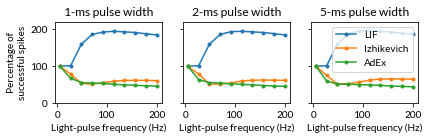

In [237]:
fig, axs = plt.subplots(1, len(pulse_widths), figsize=(6.5, 1.5), sharey=True)
axs = np.array(axs).reshape(-1)
for i in range(len(pulse_widths)):
    ax = axs[i]
    ax.set(title=f'{int(pulse_widths[i])}-ms pulse width',
           xlabel='Light-pulse frequency (Hz)',
           ylim=(0, 220))
    data = pct_spikes[i].T
    ax.plot(stim_freqs, data, marker='.')
ax.legend([ng.name for ng in ngs])
axs[0].set_ylabel('Percentage of\nsuccessful spikes')
fig.savefig('gunaydin10_3f_replicated.svg', facecolor='white', bbox_inches='tight')


Both Izhikevich and AdEx models qualitatively reproduce the decrease from 100% spike/pulse ratio. LIF does not apparently because the way it spikes at -50 mV and resets to -70 mV keeps the voltage unrealistically low, making the opsin currents unrealistically high.